## _*H2 ground state energy computed using the IQPE algorithm*_

This notebook demonstrates using QISKit ACQUA Chemistry to plot graphs of the ground state energy of the Hydrogen (H2) molecule over a range of inter-atomic distances using IQPE (Iterative Quantum Phase Estimation) algorithm. It is compared to the same energies as computed by the ExactEigensolver

This notebook populates a dictionary, that is a progammatic representation of an input file, in order to drive the qiskit_acqua_chemistry stack. Such a dictionary can be manipulated programmatically and this is indeed the case here where we alter the molecule supplied to the driver in each loop.

This notebook has been written to use the PYSCF chemistry driver. See the PYSCF chemistry driver readme if you need to install the external PySCF library that this driver requires.

In [1]:
import paths
import numpy as np
import pylab
from qiskit_acqua_chemistry import ACQUAChemistry
import time

# Input dictionary to configure QISKit ACQUA Chemistry for the chemistry problem.
acqua_chemistry_dict = {
    'driver': {'name': 'PYSCF'},
    'PYSCF': {'atom': '', 'basis': 'sto3g'},
    'operator': {'name': 'hamiltonian', 'transformation': 'full', 'qubit_mapping': 'parity'},
    'algorithm': {'name': ''},
    'initial_state': {'name': 'HartreeFock'},
}
molecule = 'H .0 .0 -{0}; H .0 .0 {0}'
algorithms = [
    {
        'name': 'IQPE',
        'num_iterations': 8,
        'num_time_slices': 100,
        'expansion_mode': 'suzuki',
        'expansion_order': 2,
    },
    {
        'name': 'ExactEigensolver'
    }
]
backends = [
    {'name': 'local_qasm_simulator', 'shots': 1},
    None
]

start = 0.5  # Start distance
by    = 1  # How much to increase distance by
steps = 10   # Number of steps to increase by
energies = np.empty([len(algorithms), steps+1])
hf_energies = np.empty(steps+1)
distances = np.empty(steps+1)

start_time = time.time()

print('Processing step __', end='')
for i in range(steps+1):
    print('\b\b{:2d}'.format(i), end='', flush=True)
    d = start + i*by/steps
    acqua_chemistry_dict['PYSCF']['atom'] = molecule.format(d/2) 
    for j in range(len(algorithms)):
        acqua_chemistry_dict['algorithm'] = algorithms[j]
        if backends[j] is not None:
            acqua_chemistry_dict['backend'] = backends[j]
        else:
            acqua_chemistry_dict.pop('backend')
        solver = ACQUAChemistry()
        result = solver.run(acqua_chemistry_dict)
        energies[j][i] = result['energy']
        hf_energies[i] = result['hf_energy']
    distances[i] = d
print(' --- complete')

print('Distances: ', distances)
print('Energies:', energies)
print('Hartree-Fock energies:', hf_energies)

print("--- %s seconds ---" % (time.time() - start_time))

Processing step 10 --- complete
Distances:  [0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5]
Energies: [[-1.05758266 -1.1115623  -1.14101558 -1.13160589 -1.12519908 -1.09709017
  -1.0793555  -1.05923308 -1.03808814 -1.01688321 -0.99628398]
 [-1.05515979 -1.11628601 -1.13618945 -1.13414767 -1.12056028 -1.10115033
  -1.07919294 -1.05674075 -1.03518627 -1.01546825 -0.99814935]]
Hartree-Fock energies: [-1.04299627 -1.10112824 -1.11734903 -1.1108504  -1.09191404 -1.06610865
 -1.03653888 -1.00510671 -0.97311062 -0.94148065 -0.91087355]
--- 2237.0829598903656 seconds ---


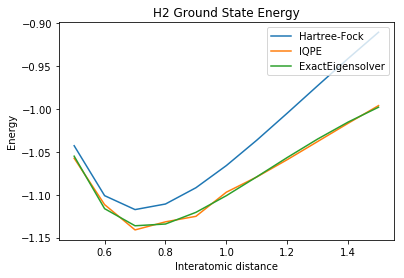

In [2]:
pylab.plot(distances, hf_energies, label='Hartree-Fock')
for j in range(len(algorithms)):
    pylab.plot(distances, energies[j], label=algorithms[j]['name'])
pylab.xlabel('Interatomic distance')
pylab.ylabel('Energy')
pylab.title('H2 Ground State Energy')
pylab.legend(loc='upper right')

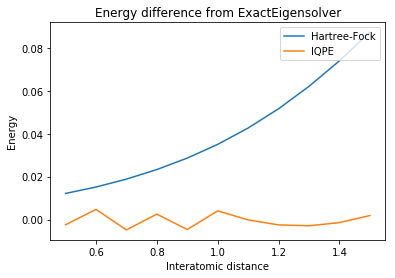

In [3]:
pylab.plot(distances, np.subtract(hf_energies, energies[1]), label='Hartree-Fock')
pylab.plot(distances, np.subtract(energies[0], energies[1]), label='IQPE')
pylab.xlabel('Interatomic distance')
pylab.ylabel('Energy')
pylab.title('Energy difference from ExactEigensolver')
pylab.legend(loc='upper right')